In [90]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [91]:
data_dir = pathlib.Path("dataset").with_suffix("")
image_count = len(list(data_dir.glob("*/*.jpg")))
print("Found {} images".format(image_count))


Found 2714 images


Test display one of the images

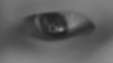

In [92]:
eyes_open = list(data_dir.glob("eyes_open/*"))
PIL.Image.open(str(eyes_open[0]))

In [93]:
batch_size = 50
img_height = 50
img_width = 80

In [94]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size = (img_height, img_width),
  batch_size = batch_size
)

Found 2714 files belonging to 2 classes.
Using 2172 files for training.


In [95]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size=batch_size
)

Found 2714 files belonging to 2 classes.
Using 542 files for validation.


In [96]:
class_names = training_dataset.class_names
print("Using class names with length {}".format(len(class_names)))
print(class_names)

Using class names with length 2
['eyes_closed', 'eyes_open']


2024-05-06 11:44:30.674445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


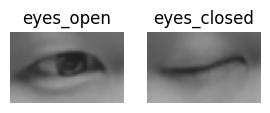

In [97]:
plt.figure(figsize=(5, 5))
for images, labels in training_dataset.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

32 is the amount of images in a single training batch
80 and 50 is the width and height of the image
3 is the array of the pixel which contains tha Red Green and Blue values

In [98]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  

(50, 50, 80, 3)
(50,)


In [99]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [100]:
#normalize layers which turns 0 ,255 to 0, 1
normalization_layer = layers.Rescaling(1./255)


In [101]:
normalized_dataset = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.18608823 0.6390981


In [102]:
classes_amount = len(class_names)


In [103]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-05-06 11:44:31.144584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


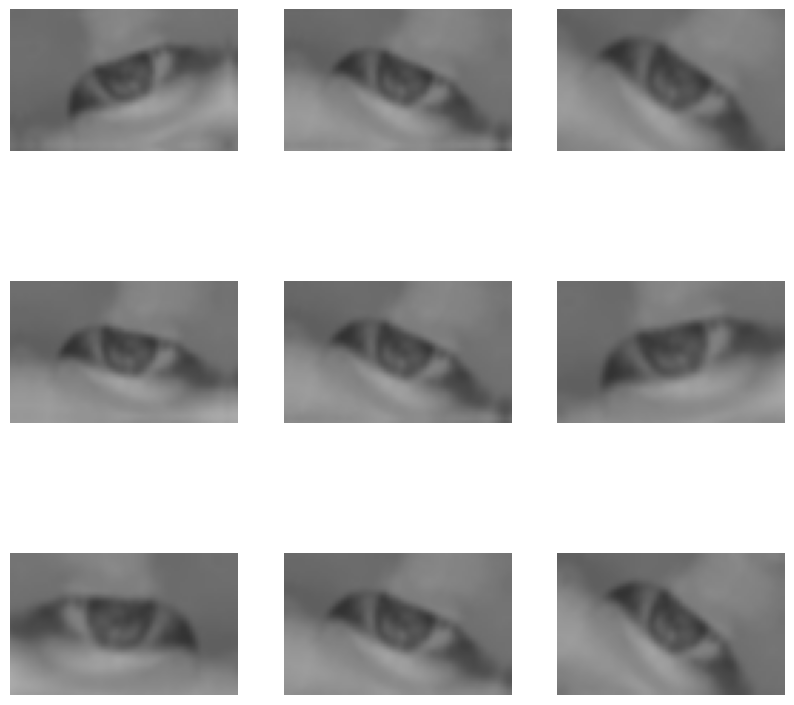

In [104]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [105]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(classes_amount, name="outputs")
])

In [106]:
import os
import datetime
model.build()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [107]:
epochs = 200
history = model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

Epoch 1/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.5438 - loss: 0.6901 - val_accuracy: 0.5554 - val_loss: 0.6863
Epoch 2/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5542 - loss: 0.6827 - val_accuracy: 0.5554 - val_loss: 0.6893
Epoch 3/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5857 - loss: 0.6629 - val_accuracy: 0.9576 - val_loss: 0.5916
Epoch 4/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9118 - loss: 0.5870 - val_accuracy: 0.9760 - val_loss: 0.5262
Epoch 5/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9466 - loss: 0.5257 - val_accuracy: 0.9594 - val_loss: 0.4872
Epoch 6/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9630 - loss: 0.4816 - val_accuracy: 0.9797 - val_loss: 0.4431
Epoch 7/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9752 - loss: 0.4389 - val_accuracy: 0.9686 - val_loss: 0.4195
Epoch 8/200
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9708 - loss: 0.4125 - val_accuracy: 0.

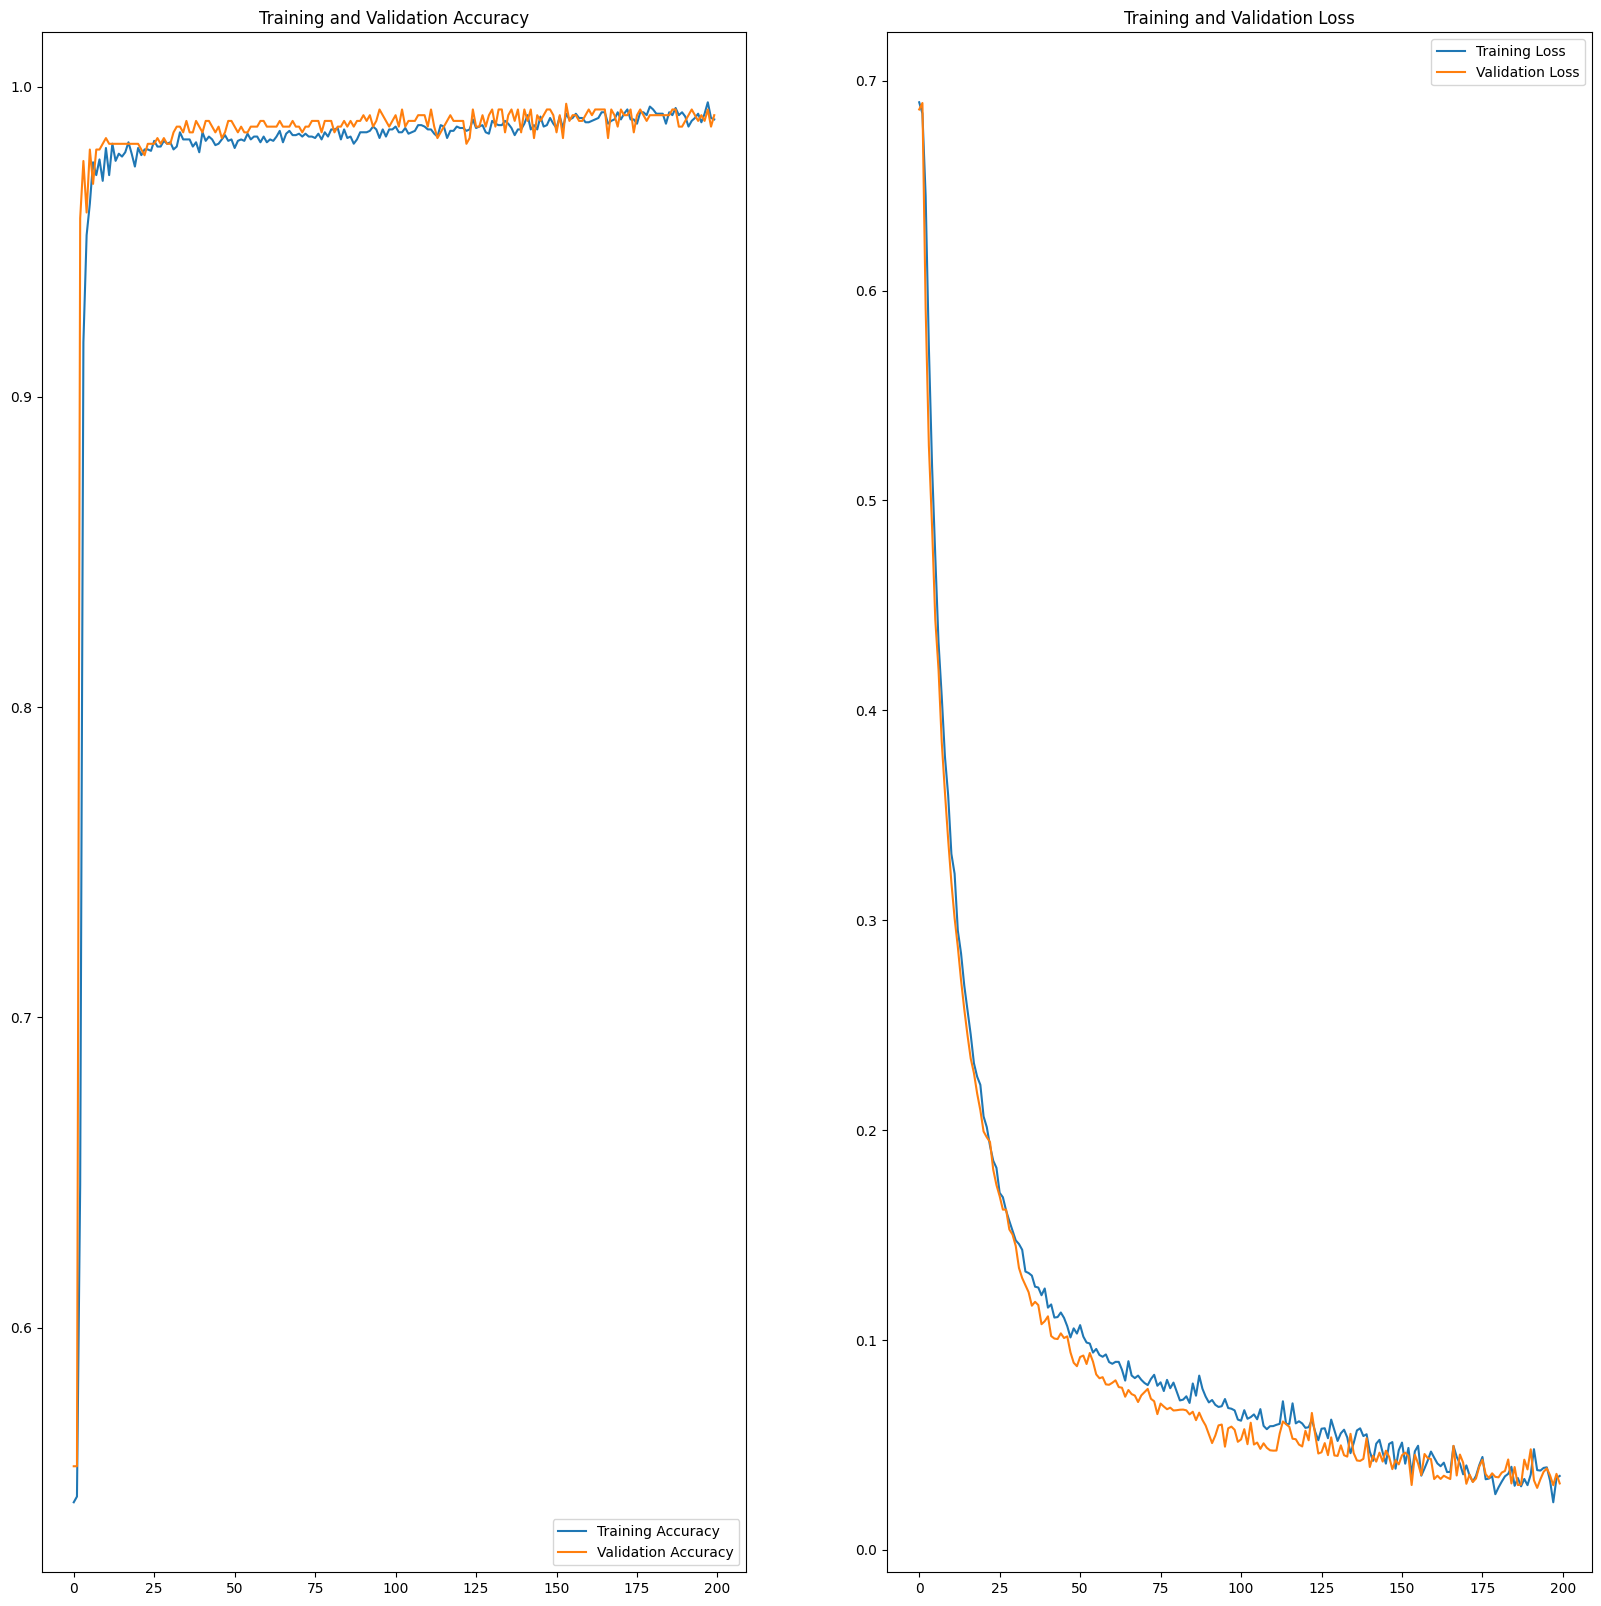

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [113]:

img = tf.keras.utils.load_img(
    "samples/41.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print(class_names)
model.save("trained.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
This image most likely belongs to eyes_closed with a 99.29 percent confidence.
['eyes_closed', 'eyes_open']
